# Ejemplo de Clasificación de Imágenes MNIST con PyTorch

# Configuración de Bibliotecas

En esta sección, importamos las bibliotecas necesarias para nuestro proyecto. Aquí hay una breve descripción de cada biblioteca:

- `torch`: Importamos PyTorch, que se utilizará para trabajar con redes neuronales.
- `torchvision`: Usamos torchvision para cargar conjuntos de datos y aplicar transformaciones a las imágenes.
- `numpy`: Importamos NumPy para realizar operaciones numéricas.
- `tqdm`: Utilizamos tqdm para mostrar barras de progreso durante la ejecución del código.
- `torch.nn`: Importamos torch.nn para definir arquitecturas de redes neuronales.

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import torch.nn as nn

# Carga de Datos

En esta sección, estamos cargando los datos del conjunto de datos MNIST, que se utilizarán para entrenar y evaluar nuestro modelo de aprendizaje automático. Hacemos lo siguiente:

### Conjunto de Entrenamiento


- `train_loader`: Creamos un DataLoader para el conjunto de entrenamiento de MNIST.
- `datasets.MNIST`: Cargamos el conjunto de datos MNIST desde la ubicación '../mnist'.
- `transform=transforms.Compose(...)`: Aplicamos transformaciones a las imágenes, incluyendo la conversión a tensores y normalización.
- `batch_size=64`: Establecemos el tamaño del lote en 64.
- `shuffle=True`: Barajamos los datos para el entrenamiento.
- `num_workers=1`: Especificamos el número de trabajadores para cargar los datos.
- `pin_memory=True`: Usamos "pin_memory" para mejorar la transferencia de datos a la GPU si está disponible.

### Conjunto de Prueba


- `test_loader`: Creamos un DataLoader para el conjunto de prueba de MNIST.
- `datasets.MNIST`: Cargamos el conjunto de datos MNIST para pruebas desde la misma ubicación.
- `transform=transforms.Compose(...)`: Aplicamos las mismas transformaciones que en el conjunto de entrenamiento.
- `batch_size=1024`: Establecemos el tamaño del lote en 1024 para las pruebas.
- `shuffle=True`: Barajamos los datos para las pruebas.
- `num_workers=1`: Especificamos el número de trabajadores para cargar los datos.
- `pin_memory=True`: Usamos "pin_memory" para mejorar la transferencia de datos a la GPU si está disponible.

In [2]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist',train=True, download=True,
               transform=transforms.Compose([transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,)),]),),
               batch_size=64, shuffle=True, num_workers=1,
               pin_memory=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist',train=False,
              transform=transforms.Compose([transforms.ToTensor(),
              transforms.Normalize((0.1307,), (0.3081,)),]),),
              batch_size=1024, shuffle=True, num_workers=1,
              pin_memory=True)

# Definición de la Arquitectura del Modelo

En esta sección, definimos la arquitectura de nuestro modelo de aprendizaje automático. Utilizamos un modelo de tipo secuencial (`Sequential`) que consta de varias capas:

- `torch.nn.Conv2d(1, 16, 8, 2, padding=3)`: Primera capa convolucional. 
    - Entrada: 1 canal (escala de grises), 16 filtros, tamaño del kernel 8x8, paso 2, relleno de 3 píxeles.
    - Función de activación: ReLU.

- `torch.nn.MaxPool2d(2, 1)`: Capa de Max Pooling.
    - Tamaño del kernel: 2x2, paso 1.

- `torch.nn.Conv2d(16, 32, 4, 2)`: Segunda capa convolucional.
    - Entrada: 16 canales (de la capa anterior), 32 filtros, tamaño del kernel 4x4, paso 2.
    - Función de activación: ReLU.

- `torch.nn.MaxPool2d(2, 1)`: Capa de Max Pooling.
    - Tamaño del kernel: 2x2, paso 1.

- `torch.nn.Flatten()`: Capa de aplanado que convierte la salida anterior en un vector.

- `torch.nn.Linear(32 * 4 * 4, 32)`: Capa completamente conectada.
    - Entrada: 32*4*4 (resultado del aplanado), salida: 32.
    - Función de activación: ReLU.

- `torch.nn.Linear(32, 10)`: Capa completamente conectada de salida.
    - Entrada: 32, salida: 10 (número de clases en tu problema).

Este modelo define una arquitectura de red neuronal convolucional (CNN) típica para problemas de clasificación. La información de entrada pasa a través de capas convolucionales, capas de agrupación (pooling), capas de aplanado y capas completamente conectadas para realizar la clasificación final en 10 clases. La función de activación ReLU se utiliza después de las capas convolucionales y completamente conectadas para introducir no linealidad en la red.


In [3]:
model = torch.nn.Sequential(torch.nn.Conv2d(1, 16, 8, 2, padding=3),
                            torch.nn.ReLU(),
                            torch.nn.MaxPool2d(2, 1), 
                            torch.nn.Conv2d(16, 32, 4, 2), 
                            torch.nn.ReLU(), 
                            torch.nn.MaxPool2d(2, 1), 
                            torch.nn.Flatten(), 
                            torch.nn.Linear(32 * 4 * 4, 32), 
                            torch.nn.ReLU(), 
                            torch.nn.Linear(32, 10))

# Definición del Optimizador

En esta sección, configuramos el optimizador que se utilizará para entrenar nuestro modelo. Utilizamos el optimizador SGD (Gradiente Descendente Estocástico) con los siguientes parámetros:

- `model.parameters()`: Pasamos los parámetros del modelo que deben ser optimizados por el SGD. Esto incluye los pesos y sesgos de todas las capas definidas anteriormente.
- `lr=0.05`: Establecemos la tasa de aprendizaje (learning rate) en 0.05. La tasa de aprendizaje controla la magnitud de los ajustes realizados en los parámetros durante el entrenamiento. Un valor más alto acelera el aprendizaje, pero puede hacer que el entrenamiento sea inestable, mientras que un valor más bajo puede hacer que el entrenamiento sea más preciso pero lento.

El optimizador SGD es uno de los algoritmos de optimización más comunes utilizados para ajustar los parámetros de una red neuronal durante el entrenamiento. Controla cómo se actualizan los pesos de la red en función de la información de retroalimentación (gradientes) proporcionada por la función de pérdida.


In [4]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

# Función de Entrenamiento y Bucle de Entrenamiento

En esta sección, definimos una función de entrenamiento y luego ejecutamos un bucle de entrenamiento para entrenar nuestro modelo.

### Función de Entrenamiento

```python
def train(model, train_loader, optimizer, epoch, device):
    # Establecemos el modelo en modo de entrenamiento
    model.train()
    
    # Definimos la función de pérdida (criterion)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Inicializamos listas para el seguimiento de pérdidas
    losses = []
    
    # Inicializamos contadores para la precisión
    correct = 0  # Contador de predicciones correctas
    total = 0    # Contador de ejemplos totales
    
    # Bucle de entrenamiento a través del conjunto de datos
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        
        # Inicializamos los gradientes en cero
        optimizer.zero_grad()
        
        # Pasamos los datos a través del modelo
        output = model(data)
        
        # Calculamos la pérdida
        loss = criterion(output, target)
        
        # Realizamos la retropropagación (backpropagation) para calcular gradientes
        loss.backward()
        
        # Actualizamos los parámetros del modelo utilizando el optimizador
        optimizer.step()
        
        # Almacenamos la pérdida actual
        losses.append(loss.item())     
                
        # Calculamos la precisión
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    # Calculamos la precisión en porcentaje
    accuracy = 100 * correct / total
        
    # Imprimimos estadísticas del entrenamiento
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {np.mean(losses):.6f} "
        f"Accuracy: {accuracy:.2f}% "  # Mostramos la precisión
       )


# Bucle de entrenamiento: entrenamos el modelo durante n épocas

- En el bucle de entrenamiento, llamamos a la función train en cada época para entrenar el modelo.   
- La función train realiza el proceso de entrenamiento, calcula la pérdida, la precisión y actualiza los parámetros del modelo utilizando el optimizador.  
- Al final de cada época, se imprimen estadísticas que incluyen la pérdida y la precisión. Este bucle se ejecuta durante 10 épocas para entrenar el modelo.

In [ ]:
def train(model, train_loader, optimizer, epoch, device):
    
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    correct = 0  # Inicializar el contador de predicciones correctas
    total = 0    # Inicializar el contador de ejemplos totales
    
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())     
                
        # Calcular la precisión
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    accuracy = 100 * correct / total  # Calcular la precisión en porcentaje
        
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {np.mean(losses):.6f} "
        f"Accuracy: {accuracy:.2f}% "  # Mostrar la precisión
       )
    
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch, device="cpu")

# Adáptar una gráfica: podemos generar una gráfica

- En caso de mostrar la evolución de la función de pérdida o el ACC a traves de las épocas, podrías adaptar una gráfica de la siguiente manera: 


In [6]:
MLossXepoc = []
ACCxEpoc = []
epochX = []

def train(model, train_loader, optimizer, epoch, device):
    
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    correct = 0  # Inicializar el contador de predicciones correctas
    total = 0    # Inicializar el contador de ejemplos totales
    

    
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())     
                
        # Calcular la precisión
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    accuracy = 100 * correct / total  # Calcular la precisión en porcentaje
    mean_loss = np.mean(losses)*100
    
    MLossXepoc.append(mean_loss)
    ACCxEpoc.append(accuracy)
    epochX.append(epoch)
    
          
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {mean_loss:.6f}%"
        f"Accuracy: {accuracy:.2f}% "  # Mostrar la precisión
       )

    
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch, device="cpu")

100%|██████████| 938/938 [00:18<00:00, 50.06it/s]


Train Epoch: 1 	Loss: 4.173314 Accuracy: 98.70% 


100%|██████████| 938/938 [00:18<00:00, 49.65it/s]


Train Epoch: 2 	Loss: 3.551540 Accuracy: 98.86% 


100%|██████████| 938/938 [00:18<00:00, 50.94it/s]


Train Epoch: 3 	Loss: 2.926086 Accuracy: 99.08% 


100%|██████████| 938/938 [00:19<00:00, 49.30it/s]


Train Epoch: 4 	Loss: 2.549555 Accuracy: 99.19% 


100%|██████████| 938/938 [00:20<00:00, 45.13it/s]


Train Epoch: 5 	Loss: 2.309746 Accuracy: 99.26% 


100%|██████████| 938/938 [00:20<00:00, 44.93it/s]


Train Epoch: 6 	Loss: 1.904847 Accuracy: 99.39% 


100%|██████████| 938/938 [00:20<00:00, 45.99it/s]


Train Epoch: 7 	Loss: 1.765618 Accuracy: 99.42% 


100%|██████████| 938/938 [00:20<00:00, 46.23it/s]


Train Epoch: 8 	Loss: 1.550183 Accuracy: 99.50% 


100%|██████████| 938/938 [00:21<00:00, 43.35it/s]


Train Epoch: 9 	Loss: 1.465900 Accuracy: 99.51% 


100%|██████████| 938/938 [00:21<00:00, 44.17it/s]

Train Epoch: 10 	Loss: 1.215434 Accuracy: 99.60% 


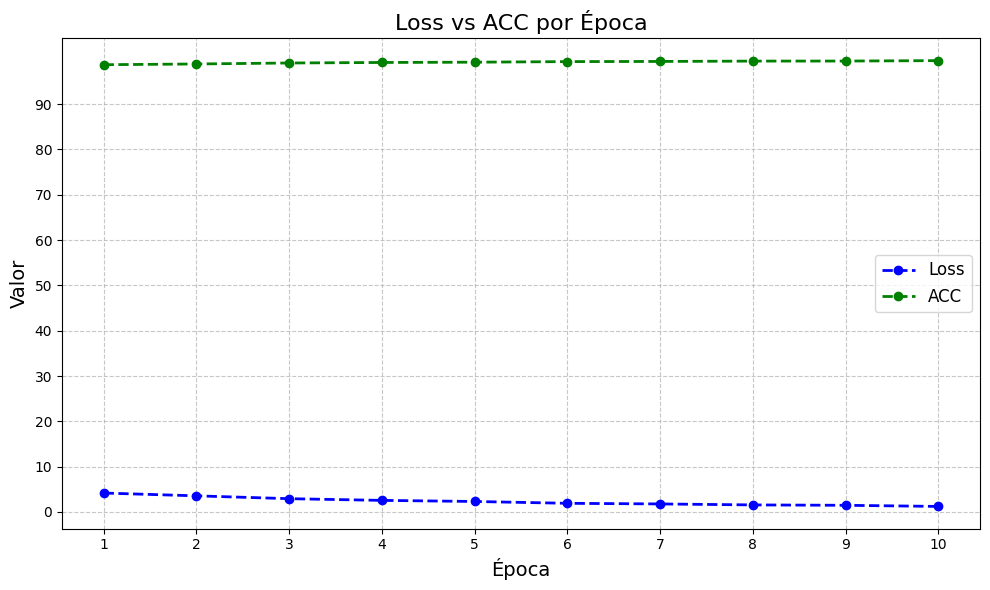

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Crear el gráfico
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.plot(epochX, MLossXepoc, marker='o', linestyle='--', color='b', label='Loss', linewidth=2)
plt.plot(epochX, ACCxEpoc, marker='o', linestyle='--', color='g', label='ACC', linewidth=2)
plt.xlabel('Época', fontsize=14)  # Etiqueta del eje x
plt.ylabel('Valor', fontsize=14)  # Etiqueta del eje y
plt.title('Loss vs ACC por Época', fontsize=16)  # Título del gráfico
plt.legend(fontsize=12)  # Leyenda
plt.grid(True, linestyle='--', alpha=0.7)  # Cuadrícula con estilo
plt.xticks(epochX)  # Valores del eje x
plt.yticks(np.arange(0, 100, 10))  # Valores del eje y (ajusta el rango según tus datos)
plt.tight_layout()  # Ajuste de diseño
plt.savefig('loss_vs_acc.png')  # Guardar el gráfico como imagen
plt.show()

## Resultados del Entrenamiento de la Red Neuronal en MNIST

Los datos proporcionados representan el rendimiento de una red neuronal entrenada en el conjunto de datos MNIST durante 10 épocas. A continuación se presentan algunas conclusiones y observaciones que se pueden hacer a partir de estos datos:

### Precisión (Accuracy)

- La precisión de la red neuronal aumenta consistentemente a medida que avanzan las épocas.
- Comienza alrededor del 98.7% en la primera época y alcanza alrededor del 99.6% en la décima época.
- Este aumento constante en la precisión sugiere que el modelo está aprendiendo y mejorando su capacidad para clasificar las imágenes correctamente.

### Pérdida (Loss)

- La pérdida de la red neuronal disminuye a lo largo de las épocas.
- Comienza con un valor de alrededor de 4.17 en la primera época y disminuye a alrededor de 1.22 en la décima época.
- La disminución de la pérdida es una señal positiva de que el modelo está mejorando su capacidad para hacer predicciones precisas. Una pérdida más baja indica que las predicciones del modelo son más cercanas a los valores reales.

### Estabilidad

- La estabilidad y la mejora gradual en la precisión y la pérdida a lo largo de las épocas sugieren que el modelo no está sufriendo de sobreajuste (overfitting) en los datos de entrenamiento, al menos hasta la décima época.
- Esto es positivo, ya que indica que el modelo está generalizando bien a nuevos datos y no está memorizando los ejemplos de entrenamiento.

### Optimización

- El proceso de entrenamiento parece estar convergiendo hacia una solución óptima, ya que tanto la precisión como la pérdida están mejorando de manera consistente.
- Sin embargo, es importante seguir monitorizando el rendimiento en conjuntos de datos de prueba para evaluar la capacidad de generalización.




## Fuentes de Referencia

Aquí se enumeran las fuentes y recursos que se utilizaron en este proyecto.

- **Entrenamiento del modelo clasificador de imágenes con PyTorch (Microsoft Learn)**
    - Autor: Quinn Radich, Roudabeh1348, v-alje
    - Fecha de publicación: 11/07/2023
    - Fuente: [Microsoft Learn](https://learn.microsoft.com/es-es/windows/ai/windows-ml/tutorials/pytorch-train-model)

- **DIFFERENTIALLY PRIVATE DEEP LEARNING IN 20 LINES OF CODE: HOW TO USE THE PYTORCH OPACUS LIBRARY (OpenMined Blog)**
    - Autor: Desconocido
    - Fecha de publicación: August 31st, 2020
    - Fuente: [OpenMined Blog](https://blog.openmined.org/differentially-private-deep-learning-using-opacus-in-20-lines-of-code/)
